In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import cv2

In [2]:
# Define transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


In [3]:
# Load a pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Modify the last fully connected layer to match the number of classes in CIFAR-10
num_ftrs = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_ftrs, 10)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
def get_attention_map(model, input_image, target_class):
    # Set model to evaluation mode
    model.eval()

    # Register hooks to get the gradients and activations from the final convolutional layer
    gradients = []
    activations = []

    def save_gradient(grad):
        gradients.append(grad)

    def forward_hook(module, input, output):
        activations.append(output)
        output.register_hook(save_gradient)

    target_layer = model.layer4[2].conv3
    target_layer.register_forward_hook(forward_hook)

    # Forward pass
    input_image = input_image.requires_grad_()
    output = model(input_image)

    # Get the score for the target class
    score = output[:, target_class]

    # Backward pass to get gradients with respect to the input image
    model.zero_grad()
    score.backward()

    # Get the gradients and activations
    gradients = gradients[0].cpu().data.numpy()
    activations = activations[0].cpu().data.numpy()

    # Compute the attention map
    weights = np.mean(gradients, axis=(2, 3))
    attention_map = np.zeros(activations.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights[0]):
        attention_map += w * activations[0, i]

    # Normalize the attention map
    attention_map = np.maximum(attention_map, 0)
    attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))
    attention_map = cv2.resize(attention_map, (input_image.shape[2], input_image.shape[3]))

    return attention_map

def visualize_attention_map(attention_map, input_image):
    # Convert input_image to numpy and normalize
    input_image = input_image.cpu().numpy().squeeze().transpose((1, 2, 0))
    input_image = input_image - np.min(input_image)
    input_image = input_image / np.max(input_image)

    # Superimpose the attention map on the input image
    heatmap = cv2.applyColorMap(np.uint8(255 * attention_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    superimposed_img = heatmap + np.float32(input_image)
    superimposed_img = superimposed_img / np.max(superimposed_img)

    # Plot the original image and the attention map
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(input_image)
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    axs[1].imshow(superimposed_img)
    axs[1].axis('off')
    axs[1].set_title('Attention Map')

    plt.show()


In [5]:
# Get a batch of test data
dataiter = iter(testloader)
images, labels = next(dataiter)

# Select a sample image and target class
input_image = images[0].unsqueeze(0).to(device)
target_class = labels[0].item()

# Compute the attention map for the selected image and class
attention_map = get_attention_map(resnet50, input_image, target_class)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


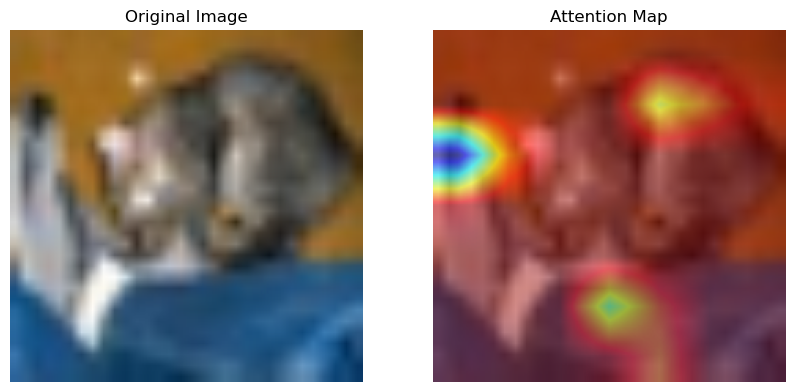

In [6]:
# Visualize the attention map
visualize_attention_map(attention_map, images[0])